In [30]:
# packages and constants
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython import display

control_axis = 'x'
h_bar = 1 # plank const
gamma = 1 # gyromagnetic ratio
B_z = 2 # magnetic field
omega_0 = gamma * B_z
if control_axis=='z':
    omega_c = omega_0 # control along z axis needs to resonate
    Rabi = omega_0 # Rabi frequency
    phi = 0 # phase shift of control laser
    T = np.pi/omega_c
elif control_axis=='x':
    omega_c = 0.2787852883338928
    Rabi = 4.801795482635498
    phi = -2.1113619804382324
    T = 0.7243056893348694
elif control_axis=='y':
    omega_c = -0.1723
    Rabi = 6.9291
    phi = 1.9001
    T = 0.475824236869812
# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_i = np.eye(2)
up = np.array([1,0]).T # excited state
down = np.array([0,1]).T # ground state
# eigenstates in x/y basis
x1 = (np.array([1,1])/np.sqrt(2)).T
x0 = (np.array([1,-1])/np.sqrt(2)).T
y1 = (np.array([1,1j])/np.sqrt(2)).T
y0 = (np.array([1,-1j])/np.sqrt(2)).T
if control_axis=='z':
    sigma_minus = np.outer(down,up.conj().T) #lowering operator
    sigma_plus = np.outer(up,down.conj().T) #raising operator
elif control_axis=='x':
    sigma_minus = np.outer(x0,x1.conj().T) #lowering operator
    sigma_plus = np.outer(x1,x0.conj().T) #raising operator
elif control_axis=='y':
    sigma_minus = np.outer(y0,y1.conj().T) #lowering operator
    sigma_plus = np.outer(y1,y0.conj().T) #raising operator
H = sigma_z * h_bar * omega_0 / 2

# Lindblad operators for relaxation and dephasing
gamma_1 = 0.1  # emission rate
gamma_2 = 0.01 # absorption rate
L1 = np.sqrt(gamma_1) * h_bar * Rabi / 2 * sigma_minus
L2 = np.sqrt(gamma_2) * h_bar * Rabi / 2 * sigma_plus
Lindblad_ops = [L1, L2]

#phi0 = up*np.sqrt(3/4) + down*np.sqrt(1/4) # initial state
#rho = np.outer(phi0,phi0)+np.array([[0j, 0j], [0j, 0j]])
rho = np.array([[0, 0], [0, 1]])+np.array([[0j, 0j], [0j, 0j]])
#rho = np.outer([0.01,np.sqrt(1-0.0001)],[0.01,np.sqrt(1-0.0001)])+np.array([[0j, 0j], [0j, 0j]])

In [31]:
def commutator(A, B):
    return np.dot(A, B) - np.dot(B, A)

def anticommutator(A, B):
    return np.dot(A, B) + np.dot(B, A)

def lindblad_term(rho, L):
    return np.dot(L, np.dot(rho, L.conj().T)) - 0.5 * anticommutator(np.dot(L.conj().T, L), rho)

def density_matrix_derivative(t, rho_flat, H, Lindblad_ops):
    rho = rho_flat.reshape(2, 2)
    if t > 0 and t<T:
        H_c = (np.exp(-(omega_c*t+phi)*1j)*sigma_plus+np.exp((omega_c*t+phi)*1j)*sigma_minus)*h_bar*Rabi/2
        d_rho = -1j * commutator(H+H_c, rho) / h_bar
    else:
        d_rho = -1j * commutator(H, rho) / h_bar
    #for L in Lindblad_ops:
    #    d_rho += lindblad_term(rho, L)
    return d_rho.flatten()

def evolve_density_matrix(rho, H, t_span, t_eval):
    rho_flat = rho.flatten()
    sol = solve_ivp(density_matrix_derivative, t_span, rho_flat, args=(H, Lindblad_ops), t_eval=t_eval, method='RK45')
    rho_t = sol.y.T.reshape(-1, 2, 2)
    return rho_t

def density_matrix_to_bloch_vector(rho):
    r_x = np.trace(np.dot(rho, sigma_x)).real
    r_y = np.trace(np.dot(rho, sigma_y)).real
    r_z = np.trace(np.dot(rho, sigma_z)).real
    return np.array([r_x, r_y, r_z])

def plot_bloch_sphere(ax):
    u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
    x = np.sin(v) * np.cos(u)
    y = np.sin(v) * np.sin(u)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color='b', alpha=0.1, linewidth=0)

    ax.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', arrow_length_ratio=0.1)
    
    ax.text(1.1, 0, 0, 'X', color='r')
    ax.text(0, 1.1, 0, 'Y', color='g')
    ax.text(0, 0, 1.1, 'Z', color='b')

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

In [32]:
# simulation config
t_span = (0, 1)
t_eval = np.linspace(0, 1, 30)
# Evolve the density matrix
rho_t = evolve_density_matrix(rho, H, t_span, t_eval)
r_t = np.array([density_matrix_to_bloch_vector(rho) for rho in rho_t])

In [33]:
# make animation
fig, axs = plt.subplots(1, 4, subplot_kw={'projection': '3d'},height_ratios=[1], figsize=(12, 4))
plt.tight_layout()
views = [(30, 45),(0, 0), (0, 90), (90, 0)]
anis = []
quivers = []
def update_quiver(num, r_t):
    global quivers, axs
    for i in range(4):
        quivers[i].remove()
        quivers[i] = axs[i].quiver(0, 0, 0, r_t[num, 0], r_t[num, 1], r_t[num, 2], color='k', arrow_length_ratio=0.1)

for ax, view in zip(axs, views):
    ax.view_init(elev=view[0], azim=view[1])
    plot_bloch_sphere(ax)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_zaxis().set_ticks([])
    quivers.append(ax.quiver(0, 0, 0, r_t[0, 0], r_t[0, 1], r_t[0, 2], color='k', arrow_length_ratio=0.1))

ani = FuncAnimation(fig, update_quiver, frames=len(t_eval), fargs=[r_t], interval=100)
html = display.HTML(ani.to_jshtml())
display.display(html)
plt.close()

c:\Users\brian\.conda\envs\data\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brian\.conda\envs\data\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


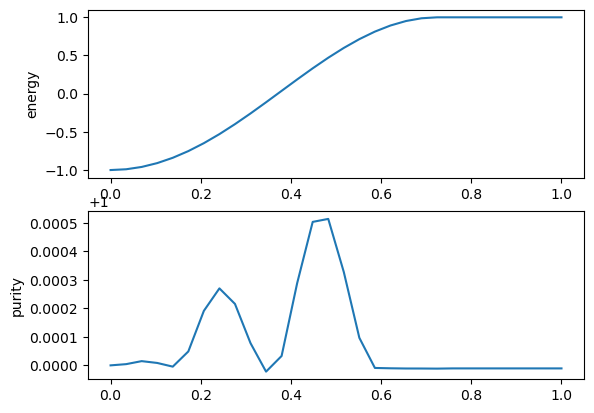

In [35]:
# plot energy and purity
energy = [np.trace(np.matmul(rho,H)) for rho in rho_t]
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_eval,energy)
plt.ylabel('energy')
purity = [np.trace(np.matmul(rho,rho)) for rho in rho_t]
plt.subplot(2,1,2)
plt.plot(t_eval,purity)
plt.ylabel('purity')
plt.show()